In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**CNN FOR MNIST**

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


**Visualization of Contributions**

**1. Feature Maps**

In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_feature_maps(model, image, layer_name="conv1", save_path="feature_maps.png"):
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0)  # add batch dimension

        # Pass through the first conv layer + activation + pooling
        if layer_name == "conv1":
            x = F.relu(F.max_pool2d(model.conv1(x), 2))
        elif layer_name == "conv2":
            x = F.relu(F.max_pool2d(model.conv1(x), 2))
            x = F.relu(F.max_pool2d(model.conv2(x), 2))
        else:
            raise ValueError("Only 'conv1' and 'conv2' are supported")

        feature_maps = x.squeeze(0)  # remove batch dimension

        # Plot the feature maps
        num_filters = feature_maps.shape[0]
        fig, axes = plt.subplots(1, num_filters, figsize=(15, 3))
        for i in range(num_filters):
            axes[i].imshow(feature_maps[i].cpu().numpy(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Filter {i+1}')
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        print(f"Feature maps saved to {save_path}")



**2. PyTorch**

Saved: conv1_feature_maps.png


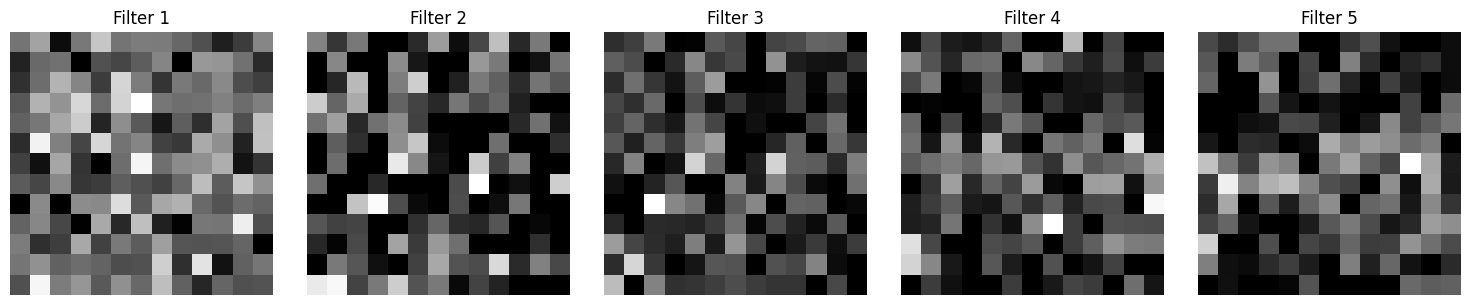

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Simple CNN with minimal filters for visualization
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3)  # Only 5 filters
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3)
        self.fc1 = nn.Linear(160, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 160)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Simulated input (like a 28x28 grayscale MNIST image)
dummy_input = torch.randn(1, 1, 28, 28)

# Initialize and run the model
model = SimpleCNN()
model.eval()

with torch.no_grad():
    conv1_output = F.relu(F.max_pool2d(model.conv1(dummy_input), 2))

# Plot and save feature maps
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(conv1_output[0, i].detach().numpy(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i+1}')

plt.tight_layout()
plt.savefig("conv1_feature_maps.png")
print("Saved: conv1_feature_maps.png")



**3. SHAP (for fc layers)**

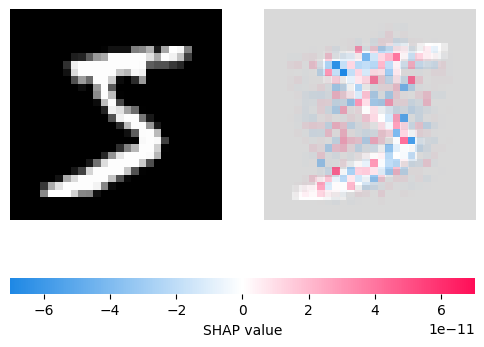

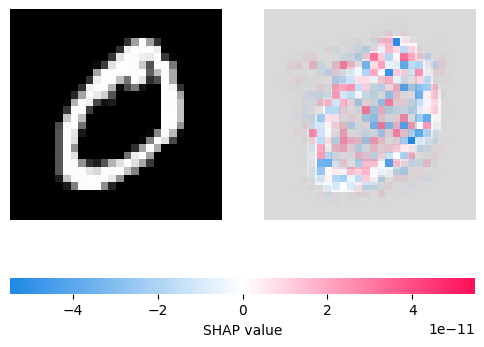

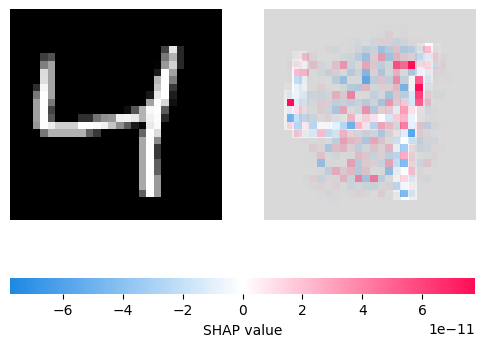

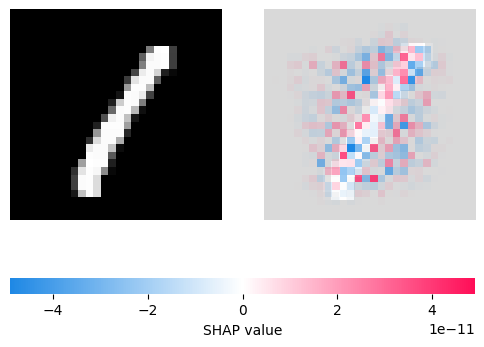

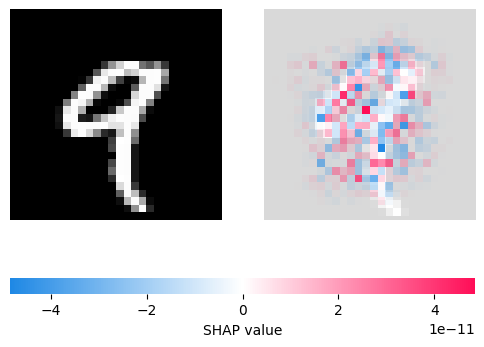

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import shap
import matplotlib.pyplot as plt
import numpy as np

# Define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3)
        self.flattened_size = None  # We'll figure this out dynamically
        self.fc1 = None
        self.fc2 = None

    def _initialize_fc_layers(self, x):
        # Called once to set fc1 and fc2 based on the actual shape of x
        self.flattened_size = x.view(x.size(0), -1).shape[1]
        self.fc1 = nn.Linear(self.flattened_size, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        if self.fc1 is None or self.fc2 is None:
            self._initialize_fc_layers(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Applying torch.exp before returning
        return torch.exp(F.log_softmax(x, dim=1))

# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=1, shuffle=True)

# Prepare background and test sets
background_images = torch.cat([mnist[i][0] for i in range(100)], dim=0).reshape(100, 1, 28, 28)
test_images = torch.cat([mnist[i][0] for i in range(5)], dim=0).reshape(5, 1, 28, 28)

# Initialize model
model = SimpleCNN()
model.eval()

# Use SHAP
explainer = shap.DeepExplainer(model, background_images)
test_images = test_images[:5]  # Reduce batch size to 5 for testing

# try:
shap_values = explainer.shap_values(test_images)
# except AssertionError as e:
#     print(f"SHAP additivity check failed: {e}")
#     print("Skipping SHAP visualization due to additivity issues.")
# else:
# Visualize SHAP values
# Iterate over each sample in the batch
for i in range(test_images.shape[0]):
    # Select the SHAP values and image for the current sample
    sample_shap_values = shap_values[i]
    sample_image = test_images[i].squeeze(0).numpy()  # Squeeze channel dimension

    # Reshape SHAP values to (height, width, num_classes)
    sample_shap_values = sample_shap_values.reshape(sample_image.shape[0], sample_image.shape[1], -1)

    # Now call shap.image_plot for each sample
    shap.image_plot(sample_shap_values, sample_image)

**4. Ablation Study**

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3)
        self.fc1 = nn.Linear(250, 50) # Changed the input size of fc1 to 250
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 250) # Changed the view to reshape to 250
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# ... (rest of the code remains the same)

# Load MNIST dataset
transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
image, label = mnist[0]  # Get one sample image

# Initialize and evaluate the original model
original_model = SimpleCNN()
original_model.eval()

# Forward pass on original model
with torch.no_grad():
    original_output = original_model(image.unsqueeze(0))
    original_prediction = original_output.argmax(dim=1).item()

# Clone and ablate (replace fc1 with identity)
ablated_model = SimpleCNN()
ablated_model.load_state_dict(original_model.state_dict())  # Copy weights
ablated_model.fc1 = nn.Identity()
# fc2 now takes input directly from conv2 output, which is 160 after flattening
ablated_model.fc2 = nn.Linear(250, 10)  # Changed the input size of fc2 to 250 to match the output of the previous layer
ablated_model.eval()

# Forward pass on ablated model
with torch.no_grad():
    ablated_output = ablated_model(image.unsqueeze(0))
    ablated_prediction = ablated_output.argmax(dim=1).item()

# Print results
print(f"True Label: {label}")
print(f"Original Model Prediction: {original_prediction}")
print(f"Ablated Model Prediction (fc1 removed): {ablated_prediction}")


True Label: 7
Original Model Prediction: 8
Ablated Model Prediction (fc1 removed): 4
